In [1]:
# %load ../env.py
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 

#Set environment variables


# Set up the local source files
TOP = '/'.join(os.getcwd().split('/')[:-2])+'/'
#TOP = "/share/home/ishah/ipynb/pb/HTTR_WF/"

LIB = TOP+'lib'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

os.environ['PYTHONPATH']=LIB


DAT_DIR = TOP + '/data/'
FIG_DIR = TOP + '/figs/'

if not os.path.exists(DAT_DIR): os.mkdir(DAT_DIR)
if not os.path.exists(FIG_DIR): os.mkdir(FIG_DIR)


from db.mongo import *

DB = openMongo(db='genra_dev_v4')

Populating the interactive namespace from numpy and matplotlib


## Load the genra prediction module

In [2]:
from rax.genrapred import *

## Find an example chemical 

In [3]:
C0 = DB.compounds.find_one(dict(name='PFOA'),dict(_id=0,synonyms=0))
sid = C0['dsstox_sid']
C0

{u'casrn': u'335-67-1',
 u'chemspider_id': 9180,
 u'created_at': datetime.datetime(2017, 4, 24, 20, 32, 19),
 u'dsstox_cid': u'DTXCID6011865',
 u'dsstox_sid': u'DTXSID8031865',
 u'gsid': 31865,
 u'inchi_key': u'SNGREZUHAYWORS-UHFFFAOYSA-N',
 u'iupac': u'Pentadecafluorooctanoic acid',
 u'mol_weight': 414.07,
 u'name': u'PFOA',
 u'pubchem_cid': 9554,
 u'smiles': u'OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F',
 u'updated_at': datetime.datetime(2017, 8, 30, 19, 10, 40)}

## Run the GenRA Prediction

In [4]:
Hits = pd.DataFrame(runGenRA(sid,DB=DB,s0=0.05,k0=20,dbg=False,sel_by='toxp_txrf')).set_index('out')

/opt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [5]:
H0=Hits.sort_values(['auc','p_val'],ascending=[True,False]).query("auc>0.1 and p_val<0.5")
H0

,a_p,a_s,a_t,auc,dsstox_sid,fp,k0,n_neg,n_pos,p_val,pred,s0,t0
out,,,,,,,,,,,,,
SUB:Adrenal Gland,0,0.120,None,0.500000,DTXSID8031865,chm_mrgn,20,12,4,0.46,Neg,0.05,0.176260
SUB:Seminal Vesicle,0,0.090,None,0.512821,DTXSID8031865,chm_mrgn,20,13,3,0.40,Neg,0.05,0.136390
MGR:Food Consumption,0,0.304,None,0.533333,DTXSID8031865,chm_mrgn,20,5,3,0.37,Neg,0.05,0.366333
SUB:Other,0,0.326,None,0.571429,DTXSID8031865,chm_mrgn,20,14,2,0.45,Neg,0.05,0.157344
SUB:Bone Marrow,0,0.096,None,0.666667,DTXSID8031865,chm_mrgn,20,13,3,0.20,Neg,0.05,0.187438
MGR:Stomach,0,0.115,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.31,Neg,0.05,0.112760
MGR:Mortality,1,0.115,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.16,Pos,0.05,0.112760
DEV:Liver,0,0.112,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.13,Neg,0.05,0.189812
DEV:Kidney,0,0.163,None,0.800000,DTXSID8031865,chm_mrgn,20,5,3,0.03,Neg,0.05,0.298850


## Visualize predictions

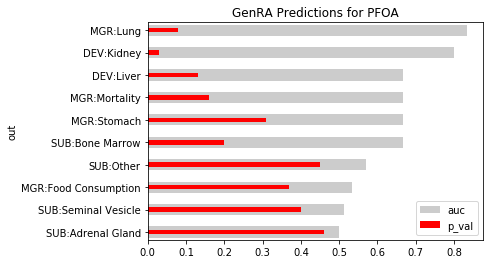

In [6]:
pl.title("GenRA Predictions for %s" % C0['name'])
H0['auc'].plot.barh(color='grey',alpha=0.4,stacked=True)
H0['p_val'].plot.barh(color='red',alpha=1,width=0.2,stacked=True)
pl.legend()

# Parallelize



In [7]:
!ls ../

db  env.py  old  parenv.py  rax


In [29]:
import ipyparallel as PP

RC=PP.Client(url_file='file:/share/home/ishah/profile_chiron_clust/security/ipcontroller-client.json')
d_view=RC[:]
lb_view = RC.load_balanced_view()
lb_view.block = True
x=file("../env.py",'r').read()
d_view.execute(x)

IOError: Connection file 'file:/share/home/ishah/profile_chiron_clust/security/ipcontroller-client.json' not found. Is a controller running?

In [24]:
d_view.execute("from rax.genrapred import *")
d_view.execute("2+2")

<AsyncResult: execute>

In [20]:
d_view.map_sync(lambda x: DB.httr_raw.count(),range(10))

CompositeError: one or more exceptions from call to method: <lambda>
[3:apply]: NameError: global name 'DB' is not defined

<AsyncResult: _push>

In [14]:
d_view.pull('x')

<AsyncResult: _pull>